# Model: LSTM

## Objective:
Our goal is to predict the **road condition type** based on vehicle sensor readings over time.
Specifically, we want to classify whether the vehicle is on:
- Asphalt
- Cobblestone
- Dirt Road

We will be using the **cleaned dataset** prepared from `01_data_cleaning.ipynb`.

## Dataset:
- Path: `dataset/cleaned_master_dataset.csv`
- Shape: 1,080,905 rows, 81 columns (after cleaning)

## Tasks Overview:
- Load the cleaned dataset
- Basic data exploration (optional, feel free to plot if needed)
- Reshape data into sequences for LSTM input
- Train **LSTM Model**
- Evaluate performance (Accuracy, Confusion Matrix, etc.)

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Run the cell below if you need to run LSTM on your Mac M2 Chip ONLY

In [6]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("List of Physical Devices:", tf.config.list_physical_devices())
print("Is GPU available?", tf.config.list_physical_devices('GPU'))

# Disable GPU acceleration (force CPU execution)
tf.config.set_visible_devices([], 'GPU')

print("Running TensorFlow on CPU only")

TensorFlow version: 2.16.1
List of Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Running TensorFlow on CPU only


In [7]:
# Load the cleaned master dataset
df = pd.read_csv('dataset/cleaned_master_dataset.csv')

# Quick check
print(df.shape)
print(df.head())

(1080905, 81)
      timestamp  acc_x_dashboard_left  acc_y_dashboard_left  \
0  1.577219e+09              0.365116              0.167893   
1  1.577219e+09              0.392649              0.176273   
2  1.577219e+09              0.409408              0.181062   
3  1.577219e+09              0.371101              0.164302   
4  1.577219e+09              0.390255              0.159514   

   acc_z_dashboard_left  acc_x_above_suspension_left  \
0              9.793961                     0.327626   
1              9.771216                     0.381496   
2              9.732909                     0.283333   
3              9.749668                     0.314458   
4              9.869378                     0.344385   

   acc_y_above_suspension_left  acc_z_above_suspension_left  \
0                     0.172733                     9.781861   
1                     0.189492                     9.699261   
2                     0.182310                     9.807000   
3                 

## Some EDA here

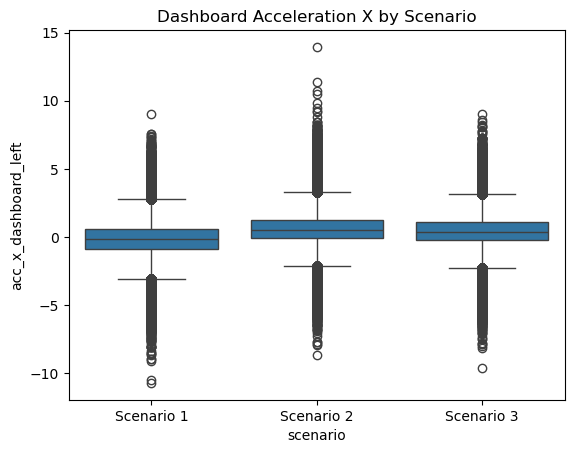

In [8]:
sns.boxplot(x='scenario', y='acc_x_dashboard_left', data=df)
plt.title('Dashboard Acceleration X by Scenario')
plt.show()

In [9]:
# Select Features (Time-Series Sensor Example)
features = df[['acc_x_dashboard_left', 'acc_y_dashboard_left', 'acc_z_dashboard_left']].values
target = df['dirt_road'].values  # Example: Predicting dirt road (0 or 1)

# Reshape data for LSTM [samples, time_steps, features]
# Here we use a simple window approach, e.g., 10 time steps per sample
sequence_length = 10

X = []
y = []

for i in range(len(features) - sequence_length):
    X.append(features[i:i + sequence_length])
    y.append(target[i + sequence_length])

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

X shape: (1080895, 10, 3), y shape: (1080895,)
Epoch 1/3


/Users/issaennab/miniforge3/envs/tf_m1/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12161/12161 ━━━━━━━━━━━━━━━━━━━━ 72s 6ms/step - accuracy: 0.7926 - loss: 0.4176 - val_accuracy: 0.8177 - val_loss: 0.3757
Epoch 2/3
12161/12161 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - accuracy: 0.8160 - loss: 0.3766 - val_accuracy: 0.8261 - val_loss: 0.3622
Epoch 3/3
12161/12161 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.8226 - loss: 0.3644 - val_accuracy: 0.8283 - val_loss: 0.3576
6756/6756 ━━━━━━━━━━━━━━━━━━━━ 6s 938us/step - accuracy: 0.8257 - loss: 0.3599
Test Accuracy: 0.8262
